# 09_SynopticConditions_DuringEvents
Maps of synoptic conditions across opening events

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

sys.path.append('./scripts/')
from LIB_SIDExbuoy import open_buoy_data, calc_velocity

font = {'size'   : 10}
FS = 10
matplotlib.rc('font', **font)

### Functions for plotting

In [2]:
def open_ERA5(date):
    
    # open ERA5 data from date
    #--------------------------
    ds_ERA5 = grab_ERA5(date, ERA5_path = f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{date.year}_daily.nc',
                        lat_range = [65,90], lon_range = [100,300], crop_time = True)
    ERA5_lons, ERA5_lats = np.meshgrid(ds_ERA5.longitude.values, ds_ERA5.latitude.values)
    MSL = ds_ERA5.msl.values/100
    U10 = ds_ERA5.u10.values
    V10 = ds_ERA5.v10.values

    return ERA5_lons, ERA5_lats, MSL, U10, V10

def create_map(date, figsize = (8,8), central_long = 205, lat_range = [68,85], lon_range = [165,242]):
    # create figure
    #--------------
    map_projection = ccrs.NorthPolarStereo(central_longitude=central_long)
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=map_projection))
    ax.patch.set_facecolor('lightgray')
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree()) 

    return fig, ax, map_projection


def plot_streamline(ax, ERA5_lons, ERA5_lats, U10, V10):
    c = ax.streamplot(ERA5_lons, ERA5_lats, *fix_cartopy_vectors(U10,V10,ERA5_lats), 
                  start_points=[map_projection.transform_point(205,71.5, src_crs=ccrs.PlateCarree())],
                  integration_direction = 'backward', 
                  arrowstyle='-',
                  color='k',transform=ccrs.PlateCarree(), linewidth=3, zorder=100)
    c.lines.set_alpha(0.3)
    
def plot_msl_f(ax, ERA5_lons, ERA5_lats, MSL, cmin = 1000, cmax = 1030):
    ax.contourf(ERA5_lons, ERA5_lats, MSL, 
            levels = np.arange(960, 1070, 2), vmin=cmin, vmax=cmax, 
            cmap='viridis', transform=ccrs.PlateCarree())

# Open buoy data

In [3]:
buoy_ds = xr.open_dataset('./data/BuoyCoordinates_cln_v0.nc')
buoy_ds.close()
buoy_ds

<xarray.Dataset>
Dimensions:    (buoyID: 23, time: 4609)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-25 ... 2021-06-01
  * buoyID     (buoyID) object '23' '24' '25' '26' '27' ... '50' '51' '52' '53'
Data variables:
    latitude   (buoyID, time) float64 ...
    longitude  (buoyID, time) float64 ...
Attributes:
    description:  half-hourly interpolated buoy positions from cleaned Hutchi...

In [4]:
#=======================================================================
TI = datetime(year=2021, month=2, day=28, hour=23, minute=30)
TF = datetime(year=2021, month=5, day=1, hour=0, minute=30)
#=======================================================================
timess = pd.to_datetime(buoy_ds.sel(time=slice(TI, TF)).time)
buoy_IDs = buoy_ds.buoyID.values


In [5]:
marker_dict = {}

for buoy in ['24', '53']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'NW'
    marker_dict[buoy]['shape'] = 's'
    marker_dict[buoy]['size'] = 20
    
for buoy in ['23', '25', '26', '29', '30', '35', '38', '40', '41', '43', '49']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'W'
    marker_dict[buoy]['shape'] = 'v'
    marker_dict[buoy]['size'] = 30    
    
for buoy in ['28', '32', '33', '36', '46', '48', '50', '51','45','27']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'E'
    marker_dict[buoy]['shape'] = 'o'
    marker_dict[buoy]['size'] = 25 

for buoy in ['31','52']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'SE'
    marker_dict[buoy]['shape'] = 'd'
    marker_dict[buoy]['size'] = 40 


### Identify opening sequences

In [6]:
# open "open area" nc file
#-------------------------
ds = (xr.open_dataset('./data/SBS_open_area.nc')).sel(time=slice('2021-03-01T00:00:00.000000000', '2021-04-30T00:00:00.000000000'))
ds.close()
dates = pd.to_datetime(ds.time.values)
open_area = ds.N_oa_g20.values

# find when there is lots (>100 km2) of new wide leads
wide_opening_dates = dates[open_area > 1000]
open_dates = wide_opening_dates
consolidated_dates = dates[open_area <= 1000]

        
# partition into opening sequences  
#---------------------------------

break_sequences={}

# fill in first value of list
ss = 0
break_sequences[ss] = [open_dates[0]]


for ii in range(1,len(open_dates)):
    # number hours difference between last time in current sequence and current time
    dD = pd.Timedelta(open_dates[ii]-break_sequences[ss][-1]).total_seconds()/(3600*24)
    # if within one day of last timein sequence, add to current sequence
    if dD <= 1:
        break_sequences[ss].append(open_dates[ii])
    # else start new sequence
    else:
        ss+=1
        break_sequences[ss] = [open_dates[ii]]#open_dates_withhours[ii]-np.timedelta64(1,'h'), 
        
opening_start_dates = np.array([])
for seq in break_sequences:
#     print(f'{break_sequences[seq][0].date()} -- {break_sequences[seq][-1].date()}')
    opening_start_dates = np.append(opening_start_dates, break_sequences[seq][0].to_pydatetime())
    
    
# add on consolidated days as final list in break sequences, just for plotting
consol_seq = list(break_sequences.keys())[-1]+1
break_sequences[consol_seq] = consolidated_dates

for seq in break_sequences:
    current_dates = break_sequences[seq]
    print(f'{current_dates[0]} --- {current_dates[-1]}')

2021-03-05 00:00:00 --- 2021-03-06 00:00:00
2021-03-08 00:00:00 --- 2021-03-11 00:00:00
2021-03-13 00:00:00 --- 2021-03-17 00:00:00
2021-03-22 00:00:00 --- 2021-03-24 00:00:00
2021-03-29 00:00:00 --- 2021-04-01 00:00:00
2021-04-13 00:00:00 --- 2021-04-14 00:00:00
2021-04-16 00:00:00 --- 2021-04-16 00:00:00
2021-04-18 00:00:00 --- 2021-04-19 00:00:00
2021-04-24 00:00:00 --- 2021-04-24 00:00:00
2021-04-26 00:00:00 --- 2021-04-30 00:00:00
2021-03-01 00:00:00 --- 2021-04-25 00:00:00


### Plotting

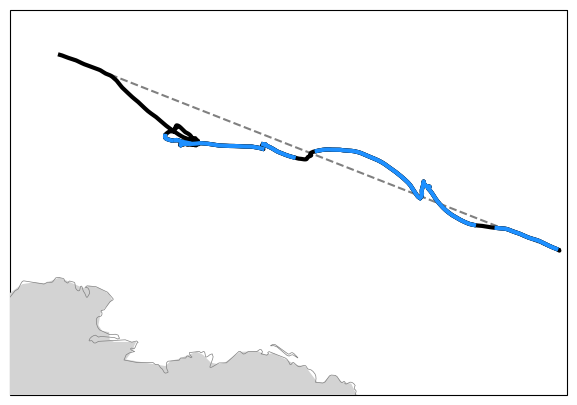

In [7]:
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(8,5), subplot_kw=dict(projection=map_projection))

lat_range = [70.2, 72.5]
lon_range = [206, 216]

# set map extent, add grid and geo features
#------------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
ax.spines['geo'].set_edgecolor('k')
add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=17)
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=16)
add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=18)


buoy_23_full = buoy_ds.sel(time=slice(TI, TF)).sel(buoyID='23')
ax.plot(buoy_23_full.longitude.values, 
        buoy_23_full.latitude.values, c='k', lw=3, transform=ccrs.PlateCarree(), zorder=101)
# ax.plot(buoy_ds.sel(time=slice(TI, TF)).sel(buoyID='23').longitude.values, 
#         buoy_ds.sel(time=slice(TI, TF)).sel(buoyID='23').latitude.values, c='lightgray', lw=2.5, transform=ccrs.PlateCarree(), zorder=101)
    
ax.plot([buoy_23_full.longitude.values[0], buoy_23_full.longitude.values[-1]],
       [buoy_23_full.latitude.values[0], buoy_23_full.latitude.values[-1]], c='gray', linestyle='dashed', transform=ccrs.PlateCarree())


for dd in [0,1,2,3,4,5,6]:
    crop_buoy = buoy_ds.sel(time=slice(break_sequences[dd][0], break_sequences[dd][-1]+timedelta(hours=23)))
    ax.plot(crop_buoy.sel(buoyID='23').longitude.values, 
            crop_buoy.sel(buoyID='23').latitude.values, c='k', lw=3, transform=ccrs.PlateCarree(), zorder=101)
    ax.plot(crop_buoy.sel(buoyID='23').longitude.values, 
            crop_buoy.sel(buoyID='23').latitude.values, c='dodgerblue', lw=3, transform=ccrs.PlateCarree(), zorder=102)


### Plotting final figure

In [ ]:

#=======
FS = 8
#=======

# sic data
file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/'
file_name='2021/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc'
geo_file='coordinates_npstere_1km_arctic.nc'

# sic cmap
ice_cmap = mpl.cm.Blues(np.linspace(0,1,20))                  # cropped cmap
ice_cmap = mpl.colors.ListedColormap(ice_cmap[:-5,:-1][::-1]) # cropped cmap
norm = matplotlib.colors.TwoSlopeNorm(vmin=80,vcenter=90,vmax=100)

# coast polgyons
#//////////////////////////////////////////////////////////////////
ds_mask = xr.open_dataset('./data/coast_mask_regions.nc')
ds_mask.close()
polyR1 = wkt.loads(str(ds_mask.R1_poly_str.values))
polyR2 = wkt.loads(str(ds_mask.R2_poly_str.values))
coast_poly = wkt.loads(str(ds_mask.coast_poly_masked_str.values))
#//////////////////////////////////////////////////////////////////


from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(7.5,7.5))

# gs = GridSpec(round(len(break_sequences)/2 +0.1),2, width_ratios=[1,1])
gs = GridSpec(round(len(break_sequences)/3 +0.5),3, width_ratios=[1,1,1])

map_projection = ccrs.NorthPolarStereo(central_longitude=210)

ax0 = fig.add_subplot(gs[0], projection=map_projection)
ax1 = fig.add_subplot(gs[1], projection=map_projection)
ax2 = fig.add_subplot(gs[2], projection=map_projection)
ax3 = fig.add_subplot(gs[3], projection=map_projection)
ax4 = fig.add_subplot(gs[4], projection=map_projection)
ax5 = fig.add_subplot(gs[5], projection=map_projection)
ax6 = fig.add_subplot(gs[6], projection=map_projection)
ax7 = fig.add_subplot(gs[7], projection=map_projection)
ax8 = fig.add_subplot(gs[8], projection=map_projection)
ax9 = fig.add_subplot(gs[9], projection=map_projection)
ax10 = fig.add_subplot(gs[10], projection=map_projection)
axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    
# for ii in range(len(break_sequences)):

for dd, seq in enumerate(break_sequences):
    
    ax = axs[dd]
    
#     map_projection = ccrs.NorthPolarStereo(central_longitude=210)
#     fig.add_subplot(gs[dd], projection=map_projection)
#     ax = fig.axes[dd]
    lat_range = [68.75, 77]
    lon_range = [200, 232]
    ax.patch.set_facecolor('lightgray')
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree()) 
    
    current_dates = break_sequences[seq]
    print(current_dates)
    
    # create figure
#     fig, ax, map_projection = create_map(date, figsize=(3.5,5),central_long = 210, lat_range = [69.5, 76], lon_range = [200, 232])
    add_land(ax, scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=16)
    add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=17)
    add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(180,260,20), linewidth=1, color='gray', alpha=0.3, zorder=4)
    
    ax.spines['geo'].set_edgecolor('k')
    ax.spines['geo'].set_linewidth(1)
    ax.spines['geo'].set_linestyle('solid')
    
    # grab ERA5 mean data across sequence
    #////////////////////////////////////////////////////
    # open ERA5 data from date
    #--------------------------
    for ii in range(len(current_dates)):
        ds_ERA5_crop = grab_ERA5(current_dates[ii], ERA5_path = f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{current_dates[0].year}_daily.nc',
                                lat_range = [65,90], lon_range = [100,300], crop_time = True)

        if ii == 0:
            msl = ds_ERA5_crop.msl.values/100
        else:
            msl += ds_ERA5_crop.msl.values/100

    MSL = msl/len(current_dates)
    
    if seq == 0:
        ERA5_lons, ERA5_lats = np.meshgrid(ds_ERA5_crop.longitude.values, ds_ERA5_crop.latitude.values)

    # msl contours
    #-------------
    CS = ax.contour(ERA5_lons, ERA5_lats, MSL, levels = np.arange(1000,1035,1), 
                    linewidths=(np.arange(1000,1035,1)-1000)/25,colors='k', zorder=15, transform=ccrs.PlateCarree())
    # label contours with manual labels 
    Coords = map_projection.transform_points(ccrs.PlateCarree(), np.array([198, 218,235]), np.array([73, 74,75.5]))
    manual_points=[]
    for spot in Coords[:,0:2]:
        manual_points.append((spot[0],spot[1]))
    ax.clabel(CS, CS.levels, inline=True,  inline_spacing=5, fontsize=FS, manual=manual_points)
    
    # msl contour legend
    # -------------------
    if dd == 10:
        ax.text(1.8, 0.21, 'sea level\npressure (hPa)', fontsize=FS, weight='normal', 
                    horizontalalignment='center', transform = ax.transAxes, zorder=100)
        ax.plot([1.6, 2], [0.1,0.1], clip_on=False, c='k', lw = 1.2, transform = ax.transAxes, zorder=100)

#     #////////////////////////////////////////////////////

    
    #////////
    # SIC //
    #///////////////////////////////////////////////////////////
    
    
    for ii in range(len(current_dates)):
        # grab OG ice data
        (lon, lat, sic) = grab_SIC_MODISAMSR(date=(current_dates[ii]).to_pydatetime(), return_vars=['lon', 'lat', 'sic_merged'],
                                 file_datapath=file_datapath, file_name=file_name, geo_file=geo_file)
        
        sic = np.float32(sic)
        sic[sic==101] = np.nan

        if ii==0:
            non_nan_counts_sic = (np.isnan(sic)==False).astype(int)
            sic[np.isnan(sic)]=0
            sic[sic==127] = np.nan
            SIC = sic
        else:
            non_nan_counts_sic += (np.isnan(sic)==False).astype(int)
            sic[np.isnan(sic)]=0
            SIC += sic

    allsic = SIC/non_nan_counts_sic
    sp = 1
    mesh = ax.pcolormesh(lon[::sp, ::sp], lat[::sp, ::sp], ma.masked_where(lon[::sp, ::sp]<100, allsic[::sp, ::sp]), 
                         norm=norm, cmap=ice_cmap, zorder=0, transform=ccrs.PlateCarree())
    
    if dd == 10:
        cb, cb_ax = add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', cb_width=0.015, 
             cb_length_fraction=[1.75, 2.15], cb_pad=-0.06, cb_ticks=[80,90,100], cb_ticklabels='auto', 
             cb_extend='neither', cb_label='SIC (%)', labelpad='auto', cb_label_placement='auto',
             cb_tick_placement='auto', cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])
    #///////////////////////////////////////////////////////////
    
    
    #//////////////
    # ice drift //
    #///////////////////////////////////////////////////////////
    for ii in range(len(current_dates)):
        
        (PP_lon, PP_lat, PP_u, PP_v) = grab_ice_Drift(date=current_dates[ii], return_vars=['lon', 'lat', 'u', 'v'], 
                                                    lat_range=[70, 90], lon_range=[100, 360])
        if ii == 0:
            non_nan_counts_u = (np.isnan(PP_u)==False).astype(int)
            PP_v[np.isnan(PP_u)]=0
            PP_u[np.isnan(PP_u)]=0
            u_ice = PP_u
            v_ice = PP_v

        else:
            non_nan_counts_u += (np.isnan(PP_u)==False).astype(int)
            PP_v[np.isnan(PP_u)]=0
            PP_u[np.isnan(PP_u)]=0
            u_ice += PP_u
            v_ice += PP_v
            
    # average daily SIC change over event
    u_ice = u_ice/non_nan_counts_u
    v_ice = v_ice/non_nan_counts_u
    sp = 4
    icevec = ax.quiver(PP_lon[::sp,::sp], PP_lat[::sp,::sp], *fix_cartopy_vectors(u_ice[::sp,::sp], v_ice[::sp,::sp], PP_lat[::sp,::sp]), 
              color=[0.6,0.6,0.6], width=0.0035, headwidth=5, headlength=5, headaxislength=5,
              scale=200,  zorder = 3, transform = ccrs.PlateCarree())

    if dd == 10:
        key = ax.quiverkey(icevec, X=1.3, Y=0.55, U=20, label = 'Sea ice drift\n20 $\mathrm{cm\;{s}^{-1}}$', labelpos='N', fontproperties={'size':FS}, transform=ccrs.PlateCarree())
        key.set(zorder = 100)
#     #///////////////////////////////////////////////////////////

    # buoy track legend
    # -------------------
    if dd == 10:
        ax.text(1.25, 0.2, 'buoy\ntracks', fontsize=FS, weight='normal', 
                horizontalalignment='center', transform = ax.transAxes, zorder=100)
        ax.plot([1.15, 1.35], [0.1,0.1], clip_on=False, c='k', lw = 1.5, transform = ax.transAxes, zorder=100)
        ax.plot([1.15, 1.35], [0.1,0.1], clip_on=False, c='r', lw = 1, transform = ax.transAxes, zorder=101)

        
    if dd <=9:
        length = len(break_sequences[dd])
        
        axs[dd].text(0.01, 0.985,f"E{dd+1} ({length} day{(length > 1)*'s'})", 
                     color='white', fontsize=FS,
                     verticalalignment='top', horizontalalignment='left',
                     bbox=dict(facecolor='k', alpha=1,edgecolor='k', boxstyle='round,pad=0.2'), 
                     transform=ax.transAxes, zorder=100)
        
        
#         add_date(fig, ax, f"E{dd+1} ({length} day{(length > 1)*'s'})", 
#                  method='anchor', boxstyle='round,pad=0.,rounding_size=0.2', 
#                  facecolor='lightgray', edgecolor='gray', zorder=100, anchor_loc=2, 
#                  anchor_prop={'size': FS, 'color': 'k'})
        
        crop_buoy = buoy_ds.sel(time=slice(break_sequences[dd][0], break_sequences[dd][-1]+timedelta(hours=23)))
        full_buoy = buoy_ds.sel(time=slice(TI, TF))
        for buoy in buoy_IDs:
            ax.plot(crop_buoy.sel(buoyID=buoy).longitude.values, 
                    crop_buoy.sel(buoyID=buoy).latitude.values, c='k', lw=1, transform=ccrs.PlateCarree(), zorder=14)
            ax.plot(crop_buoy.sel(buoyID=buoy).longitude.values, 
                    crop_buoy.sel(buoyID=buoy).latitude.values, c='r', lw=0.75, transform=ccrs.PlateCarree(), zorder=14)

    else:
        length = len(break_sequences[dd])
        
        axs[dd].text(0.01, 0.985, f"compact ({length} day{(length > 1)*'s'})", 
                     color='white', fontsize=FS,
                     verticalalignment='top', horizontalalignment='left',
                     bbox=dict(facecolor='k', alpha=1,edgecolor='k', boxstyle='round,pad=0.2'), 
                     transform=ax.transAxes, zorder=100)
        
    ax.add_geometries([coast_poly], edgecolor='gray', facecolor='None',
                      linewidth=1,
                      alpha=1, crs= ccrs.PlateCarree(), zorder=14)

    
    # label panels
    axs[dd].text(0.975, 0.025, f'{chr(97+dd)}', color='black', weight='bold', fontsize=FS,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='None', alpha=0.9,edgecolor='None', boxstyle='round,pad=0.2'), 
                transform=ax.transAxes, zorder=100)

gs.update(wspace=0.05, hspace=0.05)
plt.show()



# savename = f"./figures/LargeScaleOverview/AllForcingEvents_v3.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, transparent=False, bbox_inches="tight", pad_inches = 0.05, dpi=300)

    

[Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-06 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-10 00:00:00'), Timestamp('2021-03-11 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-03-13 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-16 00:00:00'), Timestamp('2021-03-17 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-23 00:00:00'), Timestamp('2021-03-24 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-03-29 00:00:00'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-01 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-04-13 00:00:00'), Timestamp('2021-04-14 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-04-16 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-04-18 00:00:00'), Timestamp('2021-04-19 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-04-24 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


[Timestamp('2021-04-26 00:00:00'), Timestamp('2021-04-27 00:00:00'), Timestamp('2021-04-28 00:00:00'), Timestamp('2021-04-29 00:00:00'), Timestamp('2021-04-30 00:00:00')]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u


DatetimeIndex(['2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-07', '2021-03-12', '2021-03-18', '2021-03-19',
               '2021-03-20', '2021-03-21', '2021-03-25', '2021-03-26',
               '2021-03-27', '2021-03-28', '2021-04-02', '2021-04-03',
               '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
               '2021-04-12', '2021-04-15', '2021-04-17', '2021-04-20',
               '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-25'],
              dtype='datetime64[ns]', freq=None)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:136: RuntimeWarning: invalid value encountered in divide
  allsic = SIC/non_nan_counts_sic
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:171: RuntimeWarning: invalid value encountered in divide
  u_ice = u_ice/non_nan_counts_u
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_97515/456317926.py:172: RuntimeWarning: invalid value encountered in divide
  v_ice = v_ice/non_nan_counts_u
